In [80]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3 
import seaborn as sns
import palettable.colorbrewer.diverging as pld

import numpy as np
import pandas as pd
from sklearn import preprocessing

from scipy import integrate  
#import scipy.signal as scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

%matplotlib widget

In [81]:
## Plotting parameters

palette = pld.RdYlGn_4_r
cmap = palette.mpl_colormap
transparency = 0.7
labelsize = 20
spinewidth = 3
fontsize = 26
legendsize = 20
fontweight = 'bold'
labelpad = 6
pad = 10
linewidth = 2.5


In [82]:
## Find the subfolders in the current working folder (cwd)
#cwd = os.getcwd()
cwd = '/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin'
subfolder = glob.glob(cwd + '/CsPbBr**')
subfolder.sort()
print(*subfolder, sep = '\n')  ## Print one element per line

/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin/CsPbBr_100uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin/CsPbBr_100uL_I_08uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin/CsPbBr_100uL_I_16uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin/CsPbBr_100uL_I_32uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220616_CHLin/CsPbBr_100uL_I_64uL


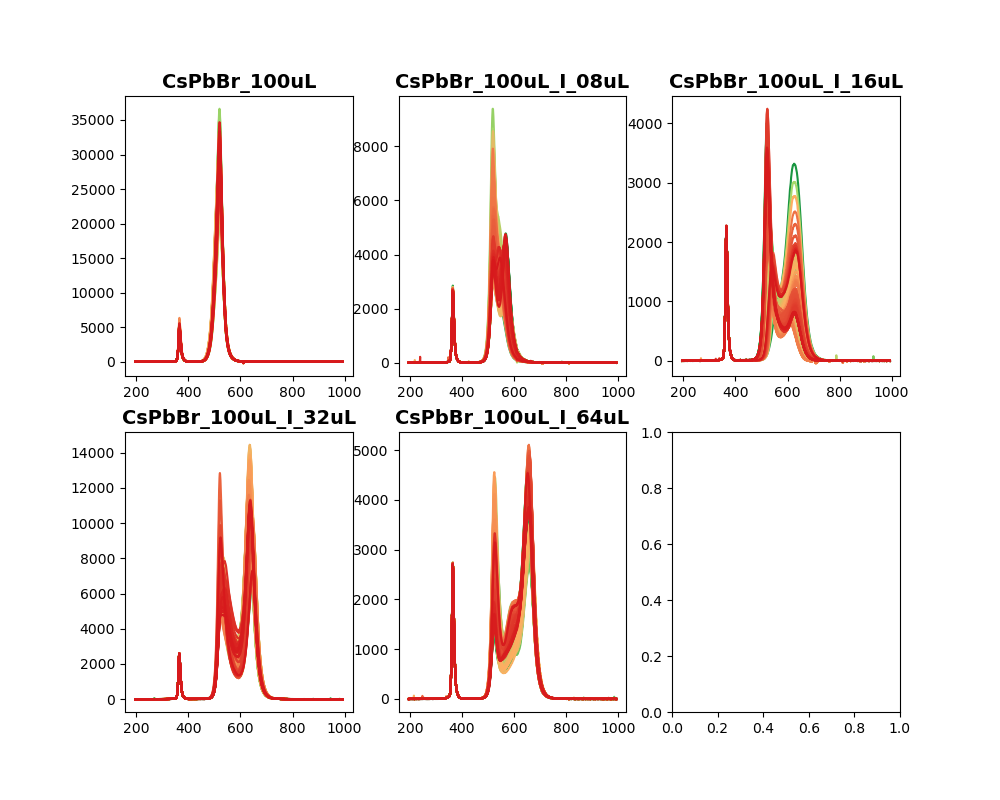

In [83]:
## Plot All PL profiles in each subfolder
f1, ax1 = plt.subplots(2, int(len(subfolder)/2)+1, figsize = (10, 8))
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

ax1 = ax1.flatten()
df = pd.DataFrame()
df_norm = pd.DataFrame()
df_norm2 = pd.DataFrame()

## Wavelength range
w1 = 250
w2 = 750

for i in range(len(subfolder)):
# for i in range(1):
    data_files = glob.glob(subfolder[i] + '/**Subt**.txt')
    data_files.sort()
    k1 = 0
    k2 = len(data_files)
    color_idx = np.linspace(0, 1, k2-k1+1)
    ax1[i].set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    df_i = pd.DataFrame()
    for j in range(k1, k2):
        df_j = pd.read_csv(data_files[j], names=['wavelength', 'intensity'], skiprows=14, sep='\t')
        ax1[i].plot(df_j.wavelength, df_j.intensity, color=cmap(color_idx[j-k1]))
        #df_i[f'Iten_{j}'] = df_j.intensity
        df_i = pd.concat([df_i, df_j.intensity], axis=1, ignore_index=True)
    
    df[f'{os.path.basename(subfolder[i])}']= df_i.mean(axis=1)
    #df_norm[f'{os.path.basename(subfolder[i])}']= df_i.mean(axis=1) / df_i.mean(axis=1).sum(axis=0)
    df_norm[f'{os.path.basename(subfolder[i])}']= df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2] / df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2].sum(axis=0)
    
    x = df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    df_norm2[f'{os.path.basename(subfolder[i])}']= x_scaled.flatten()

    
df['wavelength'] = df_j.wavelength
df_norm['wavelength'] = df_j.wavelength.loc[w1:w2]
#df_norm2['wavelength'] = df_j.wavelength.loc[w1:w2]
df_norm2.loc[0:w2-w1, 'wavelength'] = df_j.wavelength.loc[w1:w2].values

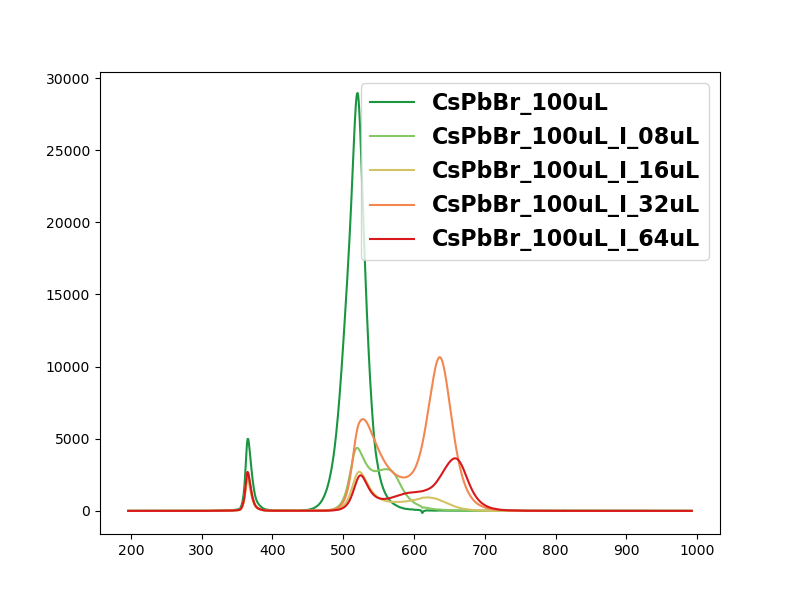

In [84]:
## Plot average PL profiles in each subfolder
f2, ax2 = plt.subplots(1, 1, figsize = (8, 6))
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(subfolder)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder)):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax2.plot(df.wavelength, getattr(df, os.path.basename(subfolder[i])), color=cmap(color_idx[i]), label=os.path.basename(subfolder[i]))

legend_properties = {'weight':'bold', 'size':16}    
ax2.legend(fontsize=legendsize, prop=legend_properties)

In [62]:
## Fit PL peaks by 1 Gaussian distribution
## http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn2.html

def _1gauss(x, A, x0, sigma, offset):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + offset

def _1gauss_fit_PL(x, y, offset=0, plot=False, plot_title=None):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(_1gauss, x, y, p0=[max(y), mean, sigma, offset])
    A = popt[0]
    x0 = popt[1]
    sigma = popt[2]
    
    fitted_result = _1gauss(x, *popt)
    residulas = y - fitted_result
    ss_res = np.sum(residulas**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_2 = 1 - (ss_res / ss_tot)
    r2 = f'R\u00b2={r_2:.2f}'
    
    if plot == True:
        plt.figure()
        plt.plot(x,y,'b+:',label='data')
        plt.plot(x,fitted_result,'ro:',label='fit\n'+r2)
        plt.legend()
        plt.title(plot_title)
        plt.show()
    else: pass
    
    return A, x0, sigma



'''
Wavelength = [] 
fwhm = []
Amplitude = []
IntegratedPl = []
Br = list(range(25,500,25))
Br = [x/1000 for x in Br]
print(Br)

def load_fldatab(x,y):
    for n in range(x,y,20):
        (wave,pl) = np.loadtxt('Fluor_Subt11__'+str(n+20)+'__'+str(n+20)+'.txt', skiprows=14, delimiter='\t', unpack='true')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('PL Intensity (Counts)')
        wave=wave[300:500]
        pl=pl[300:500]
        plt.plot(wave,pl,label='3:1 Br:CsPb')
        H, A, x0, sigma = gauss_fit(wave,pl)
        Wavelength.append(x0)
        FWHM = 2.355*sigma 
        Integral = integrate.simps(pl,wave)
        IntegratedPl.append(Integral)
        fwhm.append(FWHM)
        Amplitude.append(A)
'''


"\nWavelength = [] \nfwhm = []\nAmplitude = []\nIntegratedPl = []\nBr = list(range(25,500,25))\nBr = [x/1000 for x in Br]\nprint(Br)\n\ndef load_fldatab(x,y):\n    for n in range(x,y,20):\n        (wave,pl) = np.loadtxt('Fluor_Subt11__'+str(n+20)+'__'+str(n+20)+'.txt', skiprows=14, delimiter='\t', unpack='true')\n        plt.xlabel('Wavelength (nm)')\n        plt.ylabel('PL Intensity (Counts)')\n        wave=wave[300:500]\n        pl=pl[300:500]\n        plt.plot(wave,pl,label='3:1 Br:CsPb')\n        H, A, x0, sigma = gauss_fit(wave,pl)\n        Wavelength.append(x0)\n        FWHM = 2.355*sigma \n        Integral = integrate.simps(pl,wave)\n        IntegratedPl.append(Integral)\n        fwhm.append(FWHM)\n        Amplitude.append(A)\n"

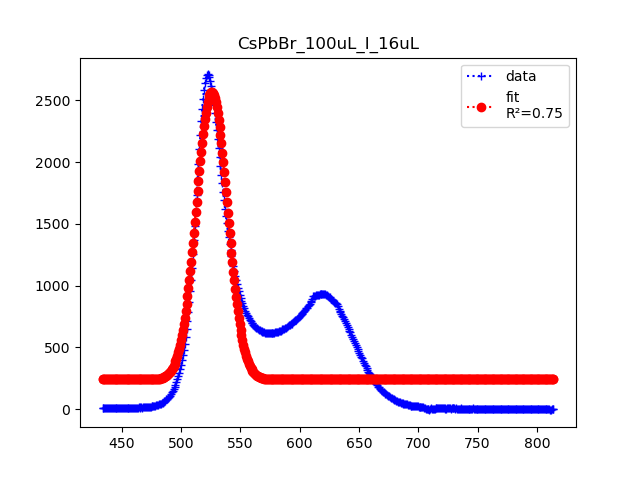

414    522.526
540    619.217
Name: wavelength, dtype: float64

In [101]:
w1 = 300
w2 = 800
i = 2
x = df[w1:w2].wavelength
y = getattr(df[w1:w2], os.path.basename(subfolder[i]))
_1gauss_fit_PL(x, y, plot=True, plot_title=os.path.basename(subfolder[i]))
peaks, _ = find_peaks(y, height=930)
plt.plot(x[w1+peaks], y[w1+peaks], "x")
#plt.show()

In [112]:
## Fit PL peaks by Multi Gaussian distributions
## http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn2.html

def _1gauss(x, A, x0, sigma, offset):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + offset

def _3gpeaks(x, A1, x1, s1, A2, x2, s2, A3, x3, s3, offset):
    return (_1gauss(x, A1, x1, s1, offset=0) +
            _1gauss(x, A2, x2, s2, offset=0) + 
            _1gauss(x, A3, x3, s3, offset=0) + offset)

def _2gauss(x, A1, x1, s1, A2, x2, s2, offset):
    return _3gauss(x, A1, x1, s1, A2, x2, s2, 0,0,1, offset)

def _2gauss_fit_PL(x, y, height=930, plot=False, plot_title=None, maxfev=100000):
    peaks, _ = find_peaks(y, height=height)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(_2gauss, x, y, p0=[y[peaks[0]], x[peaks[0]], sigma, y[peaks[-1]], x[peaks[-1]], sigma, peaks[1]-peaks[0]], maxfev=maxfev)
    #A = popt[0]
    #x0 = popt[1]
    #sigma = popt[2]
    
    fitted_result = _2gauss(x, *popt)
    residulas = y - fitted_result
    ss_res = np.sum(residulas**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_2 = 1 - (ss_res / ss_tot)
    r2 = f'R\u00b2={r_2:.2f}'
    
    if plot == True:
        plt.figure()
        plt.plot(x,y,'b+:',label='data')
        plt.plot(x,fitted_result,'ro:',label='fit\n'+r2)
        plt.legend()
        plt.title(plot_title)
        plt.show()
    else: pass
    
    #return A, x0, sigma

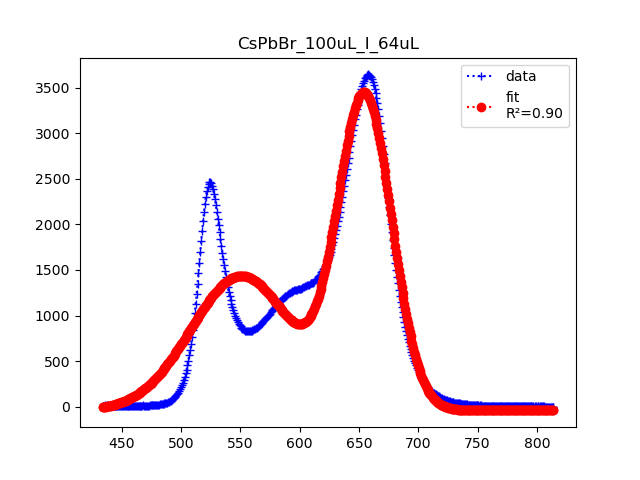

In [117]:
w1 = 300
w2 = 800
i = 4
x = np.array(df[w1:w2].wavelength)
y = np.array(getattr(df[w1:w2], os.path.basename(subfolder[i])))
_2gauss_fit_PL(x,y, height=900, plot=True, plot_title=os.path.basename(subfolder[i]))

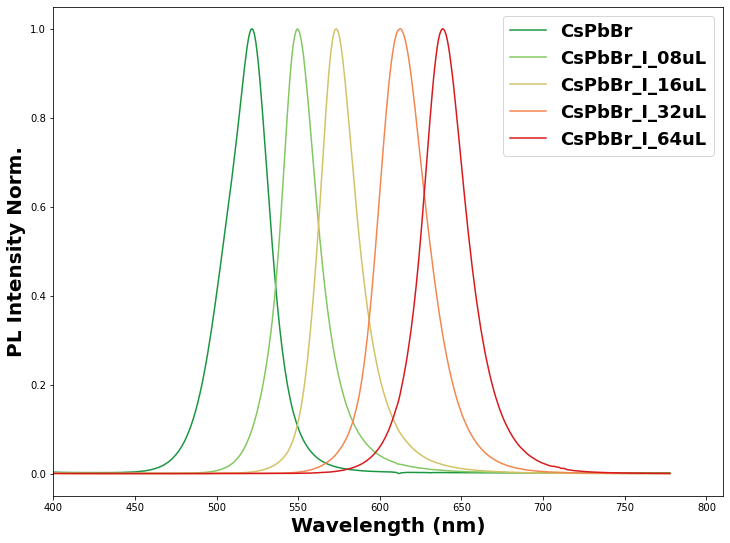

In [67]:
## Plot Normalized (by Max-min) PL profiles in each subfolder
f4, ax4 = plt.subplots(1, 1, figsize = (12, 9))
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

# mpld3.disable_notebook()
label = ['CsPbBr', 'CsPbBr_I_08uL', 'CsPbBr_I_16uL', 'CsPbBr_I_32uL', 'CsPbBr_I_64uL']
k = len(subfolder)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder)):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax4.plot(df_norm2.wavelength, getattr(df_norm2, os.path.basename(subfolder[i])), color=cmap(color_idx[i]), label=label[i])

legend_properties = {'weight':'bold', 'size':18}    
ax4.legend(prop=legend_properties)

ax4.set_xlim(400, 810)
ax4.set_xlabel('Wavelength (nm)', fontsize=labelsize, fontweight=fontweight)
ax4.set_ylabel('PL Intensity Norm.', fontsize=labelsize, fontweight=fontweight)

imag_name = '20220630_PL_CsPbBr_I.png'
plt.savefig(cwd + '/' + imag_name, dpi = 300,  transparent=False)